Importing Libraries

In [5]:
from datetime import datetime
import requests
import pandas as pd
import matplotlib.pyplot as plt
import firebase_admin
from firebase_admin import credentials, db
import seaborn as sns
import scipy.stats as stats
from scipy.stats import pearsonr, spearmanr
from scipy.signal import savgol_filter
from sklearn.preprocessing import StandardScaler

Initialising App and Fetching Data

In [8]:
# Initialize the Firebase Admin SDK with the service account
cred = credentials.Certificate('data/siotch-firebase-adminsdk-pfw4q-dbd701b65c.json')  # Service account key path
firebase_admin.initialize_app(cred, {
    'databaseURL': 'https://siotch-default-rtdb.europe-west1.firebasedatabase.app/'  # Your Firebase Realtime Database URL
})

Referencing Realtime Database

In [9]:
# Reference to the Firebase Realtime Database
ref = db.reference('/')

# Fetch the data from Firebase
data = ref.get()

Adjusting Timestamps (initialised when esp-32s were deployed)

In [10]:
# Define the actual export time
export_time = datetime.strptime("2024-12-11 15:40:00", "%Y-%m-%d %H:%M:%S")

# Define the erroneous end time
end_time = datetime.strptime("2000-01-10 22:00:49", "%Y-%m-%d %H:%M:%S")

# Calculate the time delta
time_delta = export_time - end_time

# Correct the timestamps
for key, entry in data.get("air_quality", {}).items():  # Accessing the nested 'air_quality' key
    # Check if 'timestamp' exists in the entry
    if 'timestamp' in entry:
        erroneous_timestamp = datetime.strptime(entry["timestamp"], "%Y-%m-%d %H:%M:%S")
        corrected_timestamp = erroneous_timestamp + time_delta
        entry["timestamp"] = corrected_timestamp.strftime("%Y-%m-%d %H:%M:%S")

Converting Data into Pandas DataFrame and Convert Timestamps

In [11]:
# Convert the data to a pandas DataFrame
records = []
for entry in data.get("air_quality", {}).values():  # Accessing the nested 'air_quality' key
    # Check if the required keys exist
    if "timestamp" in entry and "arch" in entry:
        records.append({
            "timestamp": entry["timestamp"],
            "arch": entry["arch"],
            "pm25": entry.get("pm25", None),  # Use .get() to avoid KeyError if 'pm25' doesn't exist
            "temperature": entry.get("temperature", None),
            "humidity": entry.get("humidity", None)
        })

df = pd.DataFrame(records)

Plot Raw Data for each arch

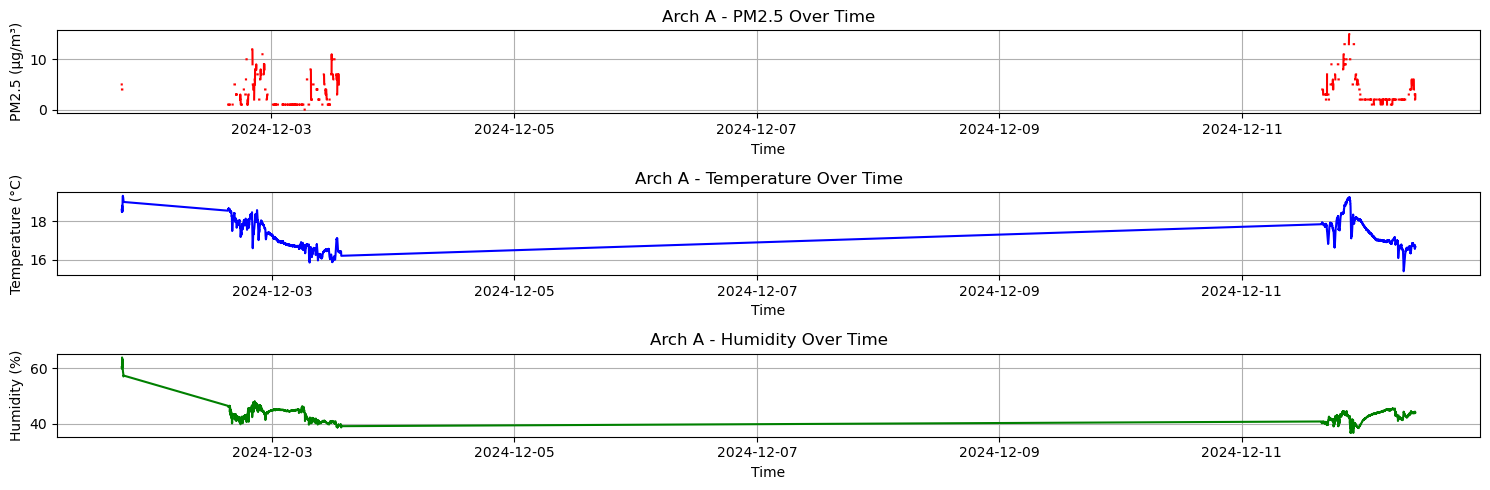

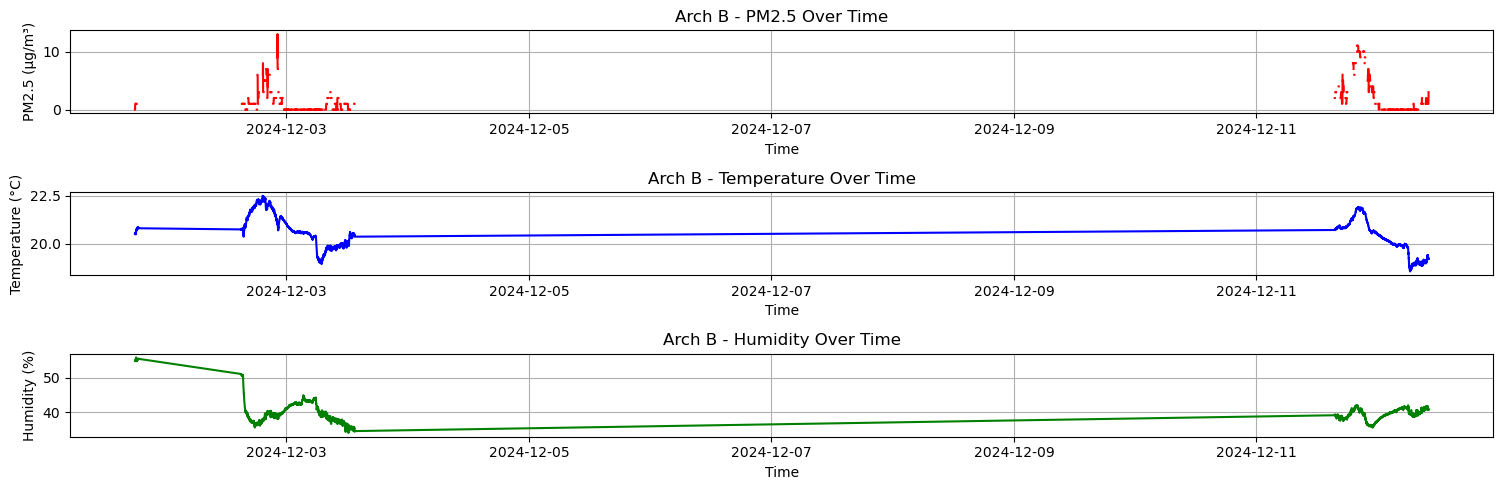

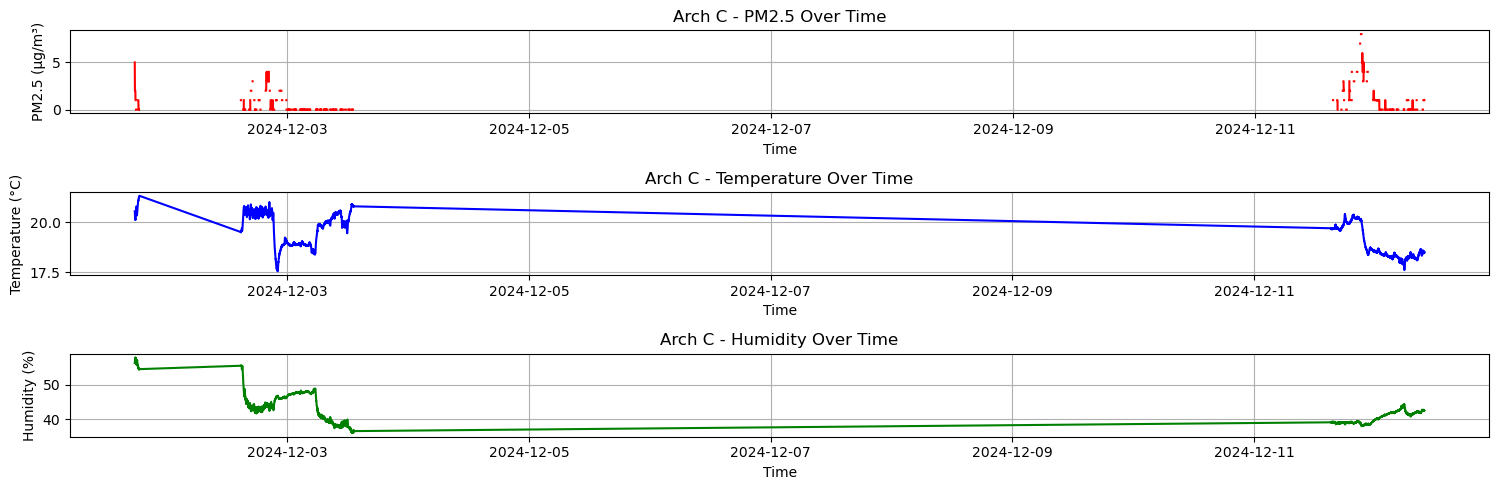

In [12]:
# Plot data for each arch
arches = df["arch"].unique()
for arch in arches:
    arch_data = df[df["arch"] == arch]

    plt.figure(figsize=(15, 5))

    # PM2.5
    plt.subplot(3, 1, 1)
    plt.plot(arch_data["timestamp"], arch_data["pm25"], label="PM2.5", color="red")
    plt.title(f"{arch} - PM2.5 Over Time")
    plt.xlabel("Time")
    plt.ylabel("PM2.5 (µg/m³)")
    plt.grid(True)

    # Temperature
    plt.subplot(3, 1, 2)
    plt.plot(arch_data["timestamp"], arch_data["temperature"], label="Temperature", color="blue")
    plt.title(f"{arch} - Temperature Over Time")
    plt.xlabel("Time")
    plt.ylabel("Temperature (°C)")
    plt.grid(True)

    # Humidity
    plt.subplot(3, 1, 3)
    plt.plot(arch_data["timestamp"], arch_data["humidity"], label="Humidity", color="green")
    plt.title(f"{arch} - Humidity Over Time")
    plt.xlabel("Time")
    plt.ylabel("Humidity (%)")
    plt.grid(True)

    plt.tight_layout()
    plt.show()


Plot Raw Data for Pm2.5, Temperature and Humidity (against each arch)

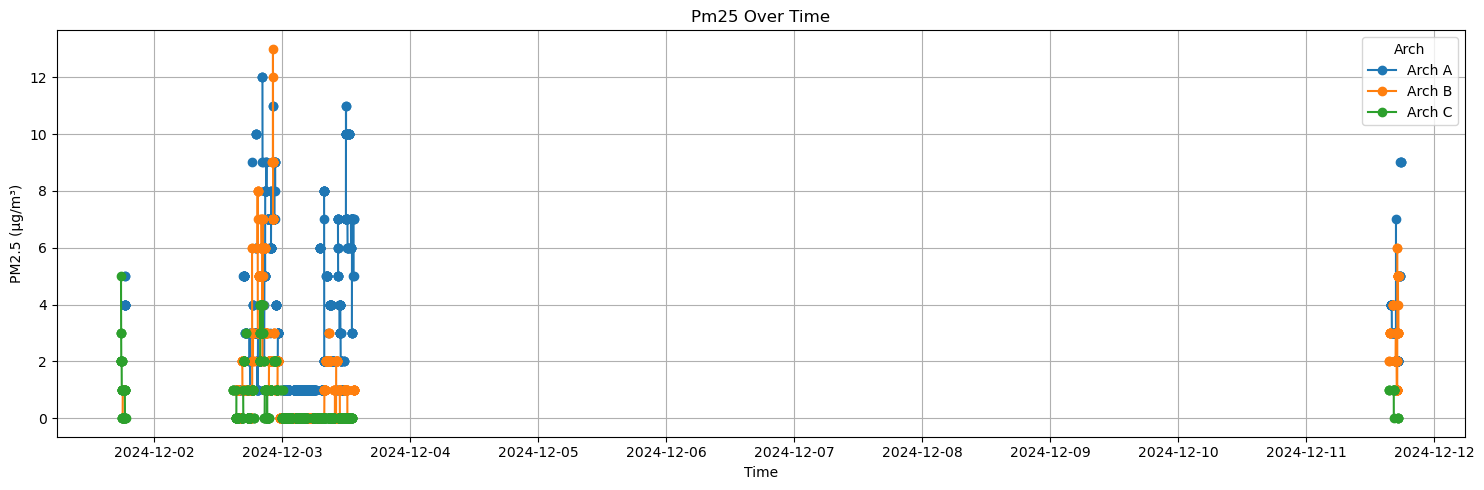

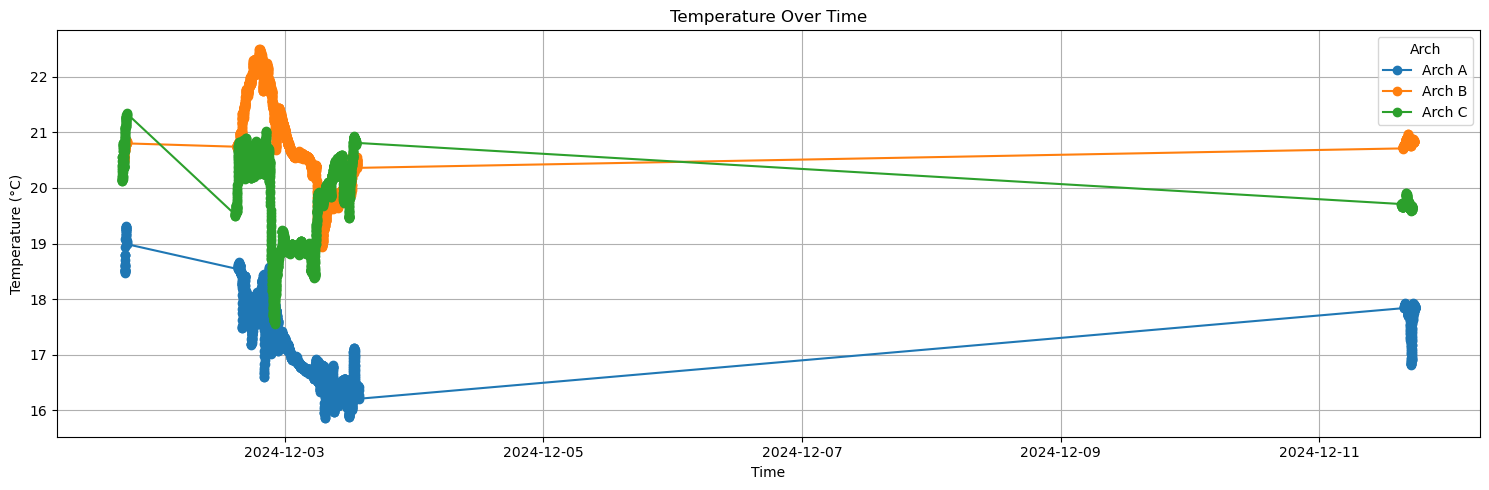

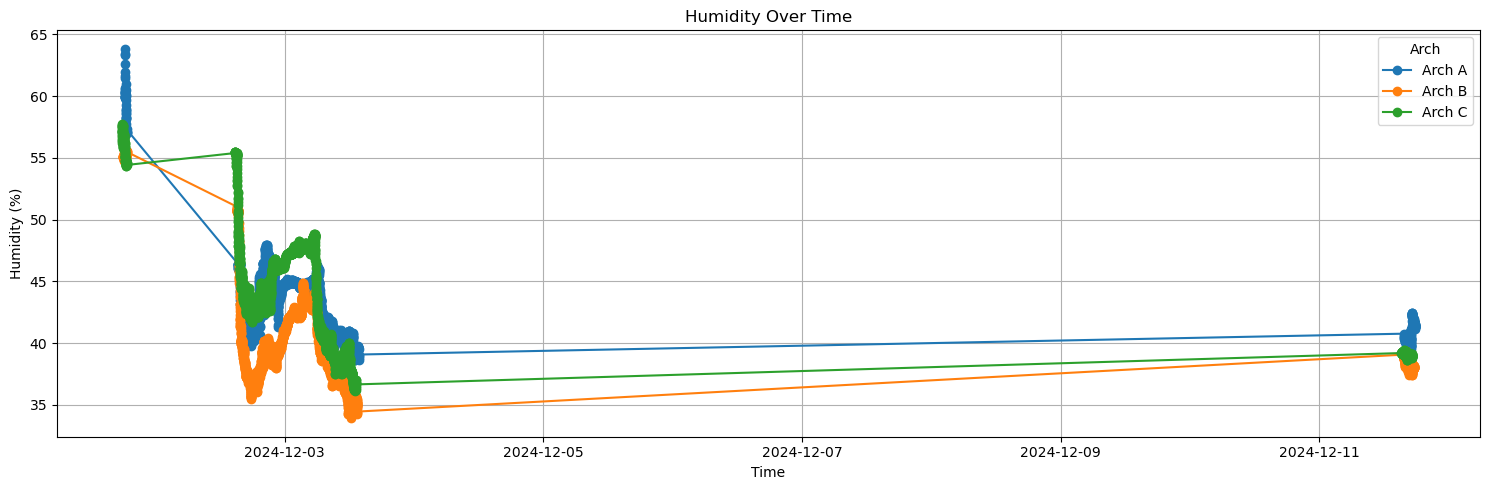

In [35]:
# Plot data for each variable (PM2.5, Temperature, Humidity)
variables = ['pm25', 'temperature', 'humidity']
variable_titles = {'pm25': 'PM2.5 (µg/m³)', 'temperature': 'Temperature (°C)', 'humidity': 'Humidity (%)'}

for var in variables:
    plt.figure(figsize=(15, 5))
    
    for arch in arches:
        arch_data = df[df["arch"] == arch]

        # Plot each arch's data for the current variable
        plt.plot(arch_data["timestamp"], arch_data[var], label=f"{arch}", marker='o')

    plt.title(f"{var.capitalize()} Over Time")
    plt.xlabel("Time")
    plt.ylabel(variable_titles[var])
    plt.legend(title="Arch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

Plotting Raw [Time-Filtered] PM2.5, Temperature and Humidity Data in most relevant time range

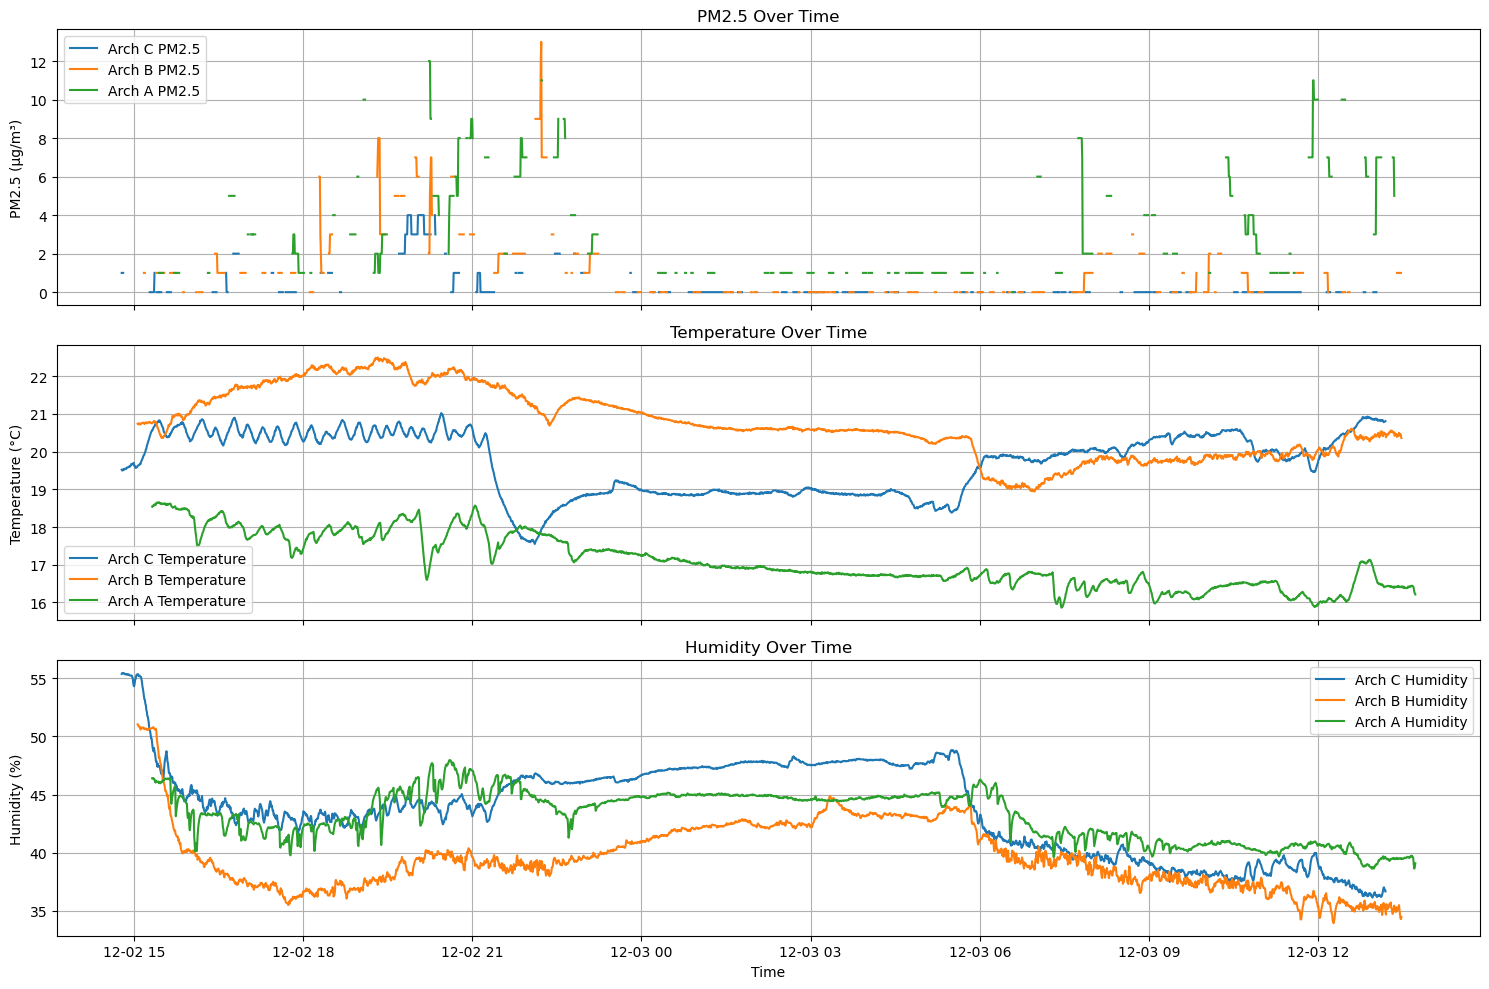

In [14]:
# Convert timestamp to datetime
df["timestamp"] = pd.to_datetime(df["timestamp"])


# Define the start and end time for filtering
start_time = datetime.strptime("2024-12-02 14:47:06", "%Y-%m-%d %H:%M:%S")
end_time = datetime.strptime("2024-12-03 15:28:06", "%Y-%m-%d %H:%M:%S")

# Filter the DataFrame to only include data within the specified time period
filtered_df = df[(df["timestamp"] >= start_time) & (df["timestamp"] <= end_time)]

# Plot data with overlays for each arch
arches = filtered_df["arch"].unique()

# Create subplots for PM2.5, temperature, and humidity
fig, axes = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# PM2.5
for arch in arches:
    arch_data = filtered_df[filtered_df["arch"] == arch]
    axes[0].plot(arch_data["timestamp"], arch_data["pm25"], label=f"{arch} PM2.5")
axes[0].set_title("PM2.5 Over Time")
axes[0].set_ylabel("PM2.5 (µg/m³)")
axes[0].grid(True)
axes[0].legend()

# Temperature
for arch in arches:
    arch_data = filtered_df[filtered_df["arch"] == arch]
    axes[1].plot(arch_data["timestamp"], arch_data["temperature"], label=f"{arch} Temperature")
axes[1].set_title("Temperature Over Time")
axes[1].set_ylabel("Temperature (°C)")
axes[1].grid(True)
axes[1].legend()

# Humidity
for arch in arches:
    arch_data = filtered_df[filtered_df["arch"] == arch]
    axes[2].plot(arch_data["timestamp"], arch_data["humidity"], label=f"{arch} Humidity")
axes[2].set_title("Humidity Over Time")
axes[2].set_ylabel("Humidity (%)")
axes[2].grid(True)
axes[2].legend()

# Set common x-axis label
plt.xlabel("Time")
plt.tight_layout()
plt.show()


Plotting Raw [Time Filtered] PM2.5 Data with Bands for WHO Recommendations

Applying a Combination of Smoothing (Mean imputation, window size 10) and Interpolation to Smooth Data for Pm2.5. For Temperature and Humidity, they're smoothed via the Savitzky-Golay filter

<Figure size 1500x500 with 0 Axes>

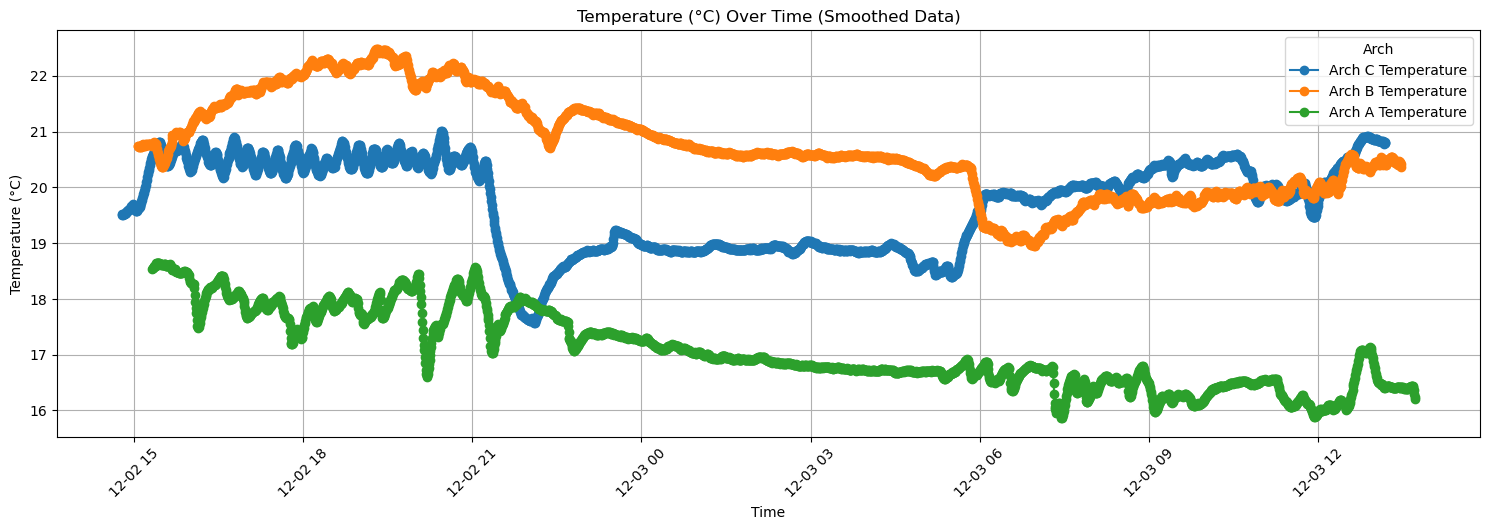

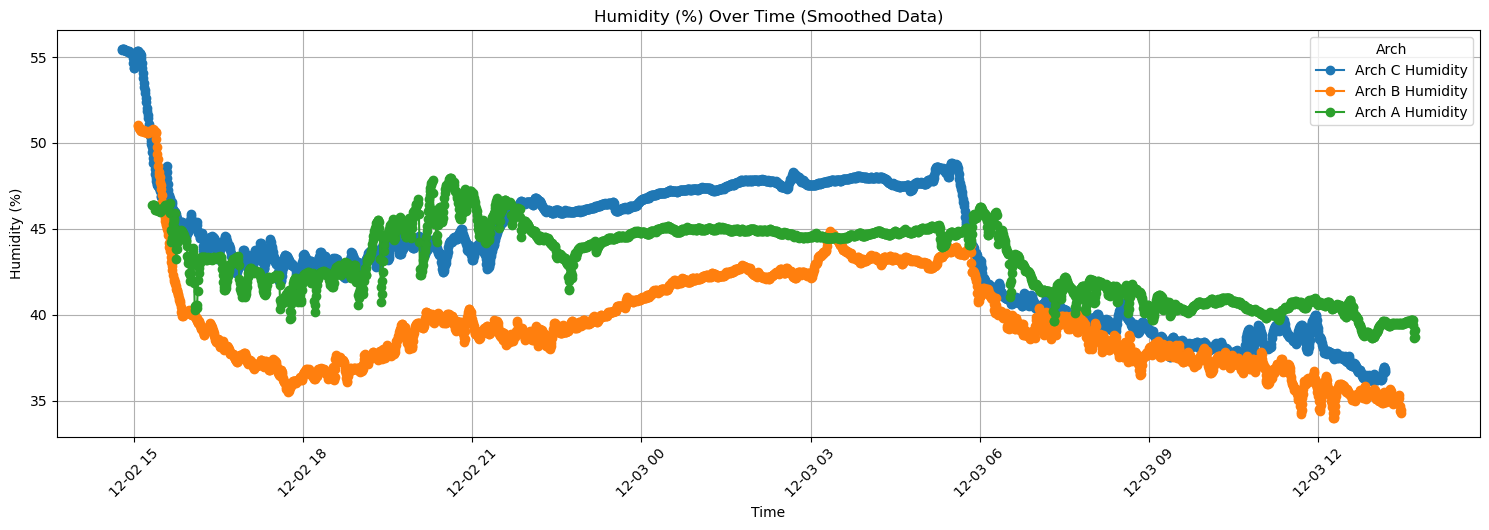

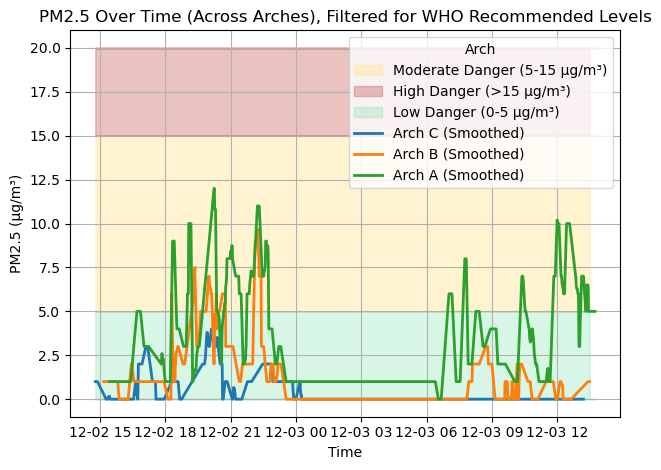

In [146]:
df_filtered = df_filtered.copy()

# Apply Savitzky-Golay filter
window_size = 5  # Odd number for symmetry
poly_order = 2     # Polynomial order for the smoothing curve

# For each arch, smooth the temperature and humidity data
df_filtered['temperature_smooth'] = df_filtered.groupby('arch')['temperature'].transform(lambda x: savgol_filter(x, window_size, poly_order))
df_filtered['humidity_smooth'] = df_filtered.groupby('arch')['humidity'].transform(lambda x: savgol_filter(x, window_size, poly_order))

# Applying large smoothing window (window size 10) for more pronounced smoothing
df_filtered['pm25_smooth'] = df_filtered.groupby('arch')['pm25'].rolling(window=10, min_periods=1).mean().reset_index(level=0, drop=True)

# Apply linear interpolation for missing values to make the data smoother
df_filtered['pm25_smooth'] = df_filtered.groupby('arch', group_keys=False)['pm25_smooth'].apply(lambda x: x.interpolate(method='linear', limit_direction='forward'))

# Create the smoothed plot
plt.figure(figsize=(15, 5))


# Plot the smoothed temperature and humidity data
variables = ['temperature', 'humidity']
variable_titles = {'temperature': 'Temperature (°C)', 'humidity': 'Humidity (%)'}

# Plotting each variable
for var in variables:
    plt.figure(figsize=(15, 5))
    
    for arch in df_filtered['arch'].unique():
        arch_data = df_filtered[df_filtered["arch"] == arch]

        # Plot the smoothed data for each arch
        plt.plot(arch_data["timestamp"], arch_data[f'{var}_smooth'], label=f"{arch} {var.capitalize()}", marker='o')

    plt.title(f"{variable_titles[var]} Over Time (Smoothed Data)")
    plt.xlabel("Time")
    plt.ylabel(variable_titles[var])
    plt.legend(title="Arch")
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

# Plot the yellow, red, and green regions again (same as before)
plt.fill_between(df_filtered["timestamp"], 5, 15, color="#FFE8A3", alpha=0.5, label="Moderate Danger (5-15 µg/m³)")
plt.fill_between(df_filtered["timestamp"], 15, 20, color="#BC3B2F", alpha=0.3, label="High Danger (>15 µg/m³)")
plt.fill_between(df_filtered["timestamp"], 0, 5, color="#3DD483", alpha=0.2, label="Low Danger (0-5 µg/m³)")

# Plot the smoothed PM2.5 data for each arch
for arch in arches:
    arch_data = df_filtered_pm25[df_filtered_pm25["arch"] == arch]
    plt.plot(arch_data["timestamp"], arch_data["pm25_smooth"], label=f"{arch} (Smoothed)", linestyle='-', linewidth=2)

# Add labels and title for the smoothed plot
plt.title("PM2.5 Over Time (Across Arches), Filtered for WHO Recommended Levels")
plt.xlabel("Time")
plt.ylabel("PM2.5 (µg/m³)")
plt.legend(title="Arch")
plt.grid(True)

# Tighten layout
plt.tight_layout()

# Show the smoothed plot
plt.show()


^The WHO recommends a maximum 5 µg/m³ PM2.5 average annually, with a 99th percentile (i.e. 3–4 exceedance days per year) 24 Hour maximum of 15 µg/m³.

Smoothing temp/humidity

Normalising Data

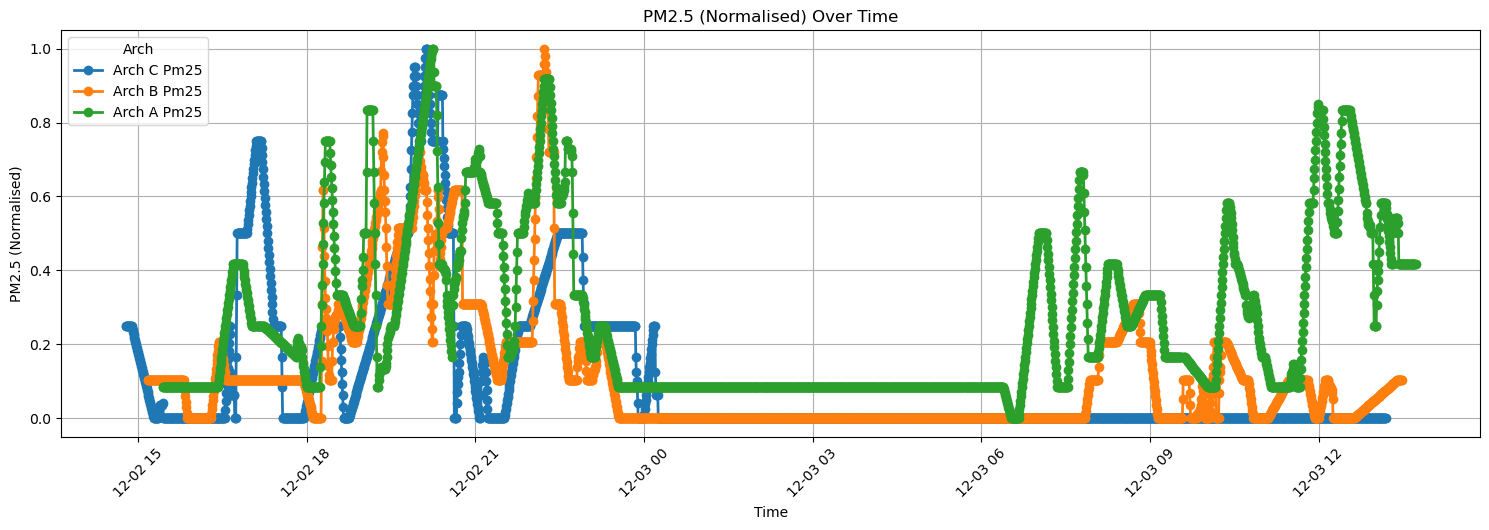

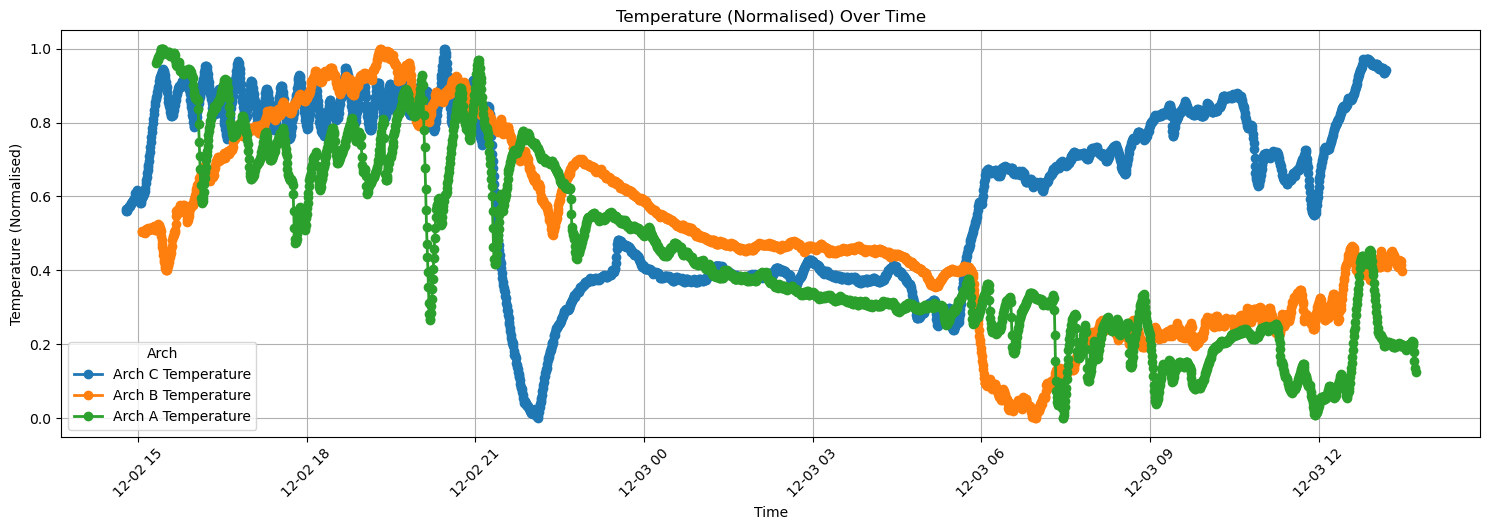

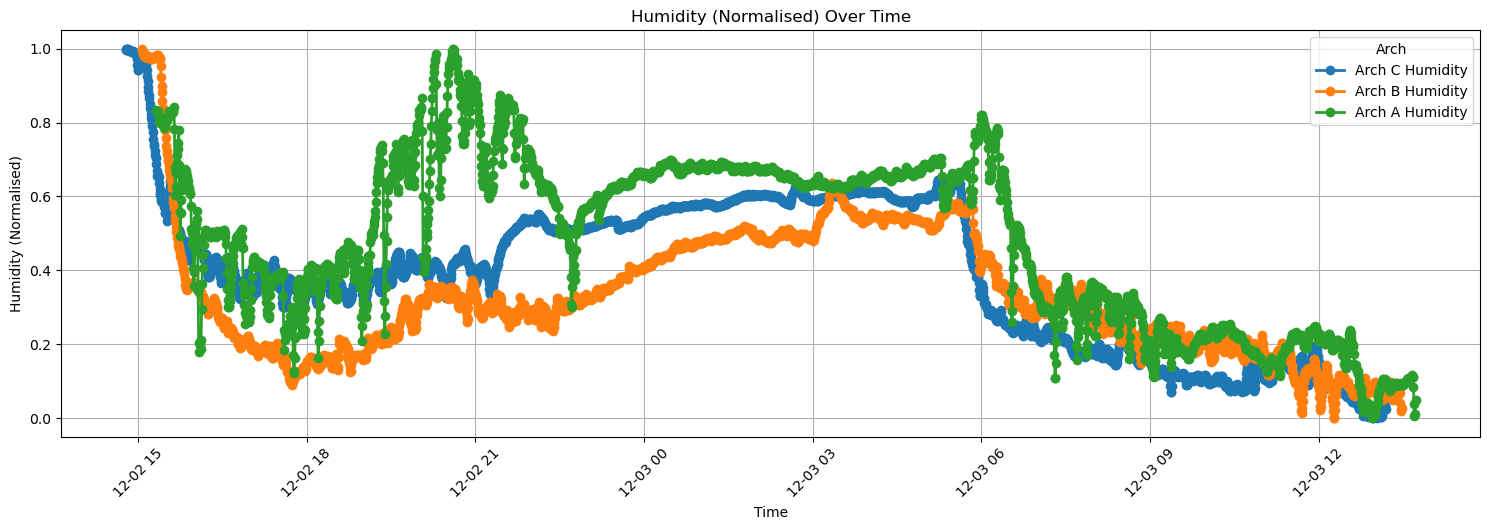

In [134]:
# Min-max normalisation function
def normalise(series):
    return (series - series.min()) / (series.max() - series.min())

# Plot the normalised data for each variable
variables = ['pm25_smooth', 'temperature_smooth', 'humidity_smooth']
variable_titles = {
    'pm25_smooth': 'PM2.5 (Normalised)',
    'temperature_smooth': 'Temperature (Normalised)',
    'humidity_smooth': 'Humidity (Normalised)'
}

# Loop through each variable to plot normalised data
for var in variables:
    plt.figure(figsize=(15, 5))

    for arch in df_filtered['arch'].unique():
        # Filter data for the current arch
        arch_data = df_filtered[df_filtered["arch"] == arch].copy()

        # Normalise the data for the current variable within the current arch
        arch_data[f'{var}_norm'] = normalise(arch_data[var])

        # Plot the normalised data for the current arch
        plt.plot(
            arch_data["timestamp"],
            arch_data[f'{var}_norm'],
            label=f"{arch} {var.split('_')[0].capitalize()}",
            marker='o',  # Keep markers for data points
            linestyle='-',  # Add lines to connect the points
            linewidth=2  # Adjust line width for better visibility
        )


    # Add title, labels, and legend
    plt.title(f"{variable_titles[var]} Over Time")
    plt.xlabel("Time")
    plt.ylabel(variable_titles[var])
    plt.legend(title="Arch")
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()

Calculating Pearson and Spearman Correlations

In [137]:
# List of arches and relevant variables
arches = df_filtered['arch'].unique()
correlations = []

# For each arch, calculate Pearson's and Spearman's correlations between PM2.5 vs Temperature and PM2.5 vs Humidity
for arch in arches:
    arch_data = df_filtered[df_filtered['arch'] == arch]
    
    # Remove rows with NaN or Inf values in the relevant columns
    arch_data_clean = arch_data[
        arch_data[['pm25_norm', 'temperature_norm', 'humidity_norm']].applymap(np.isfinite).all(axis=1)
    ]
    
    # PM2.5 vs Temperature correlation
    pearson_pm25_temp, _ = stats.pearsonr(arch_data_clean['pm25_norm'], arch_data_clean['temperature_norm'])
    spearman_pm25_temp, _ = stats.spearmanr(arch_data_clean['pm25_norm'], arch_data_clean['temperature_norm'])
    
    # PM2.5 vs Humidity correlation
    pearson_pm25_humidity, _ = stats.pearsonr(arch_data_clean['pm25_norm'], arch_data_clean['humidity_norm'])
    spearman_pm25_humidity, _ = stats.spearmanr(arch_data_clean['pm25_norm'], arch_data_clean['humidity_norm'])
    
    # Store the results
    correlations.append({
        'arch': arch,
        'pearson_pm25_temp': pearson_pm25_temp,
        'spearman_pm25_temp': spearman_pm25_temp,
        'pearson_pm25_humidity': pearson_pm25_humidity,
        'spearman_pm25_humidity': spearman_pm25_humidity
    })

# Convert results to a DataFrame for easier readability
correlation_df = pd.DataFrame(correlations)

# Display the results
print(correlation_df)

     arch  pearson_pm25_temp  spearman_pm25_temp  pearson_pm25_humidity  \
0  Arch C           0.089851            0.097440               0.142931   
1  Arch B           0.515356            0.492275              -0.242421   
2  Arch A           0.141050            0.087185              -0.205374   

   spearman_pm25_humidity  
0                0.129866  
1               -0.443089  
2               -0.322367  


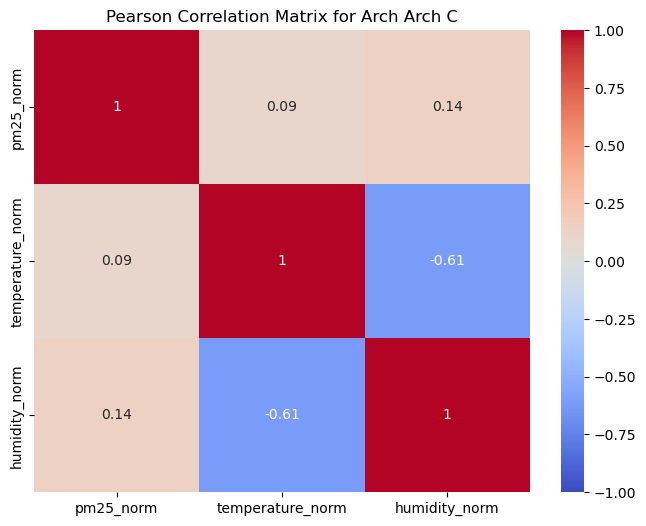

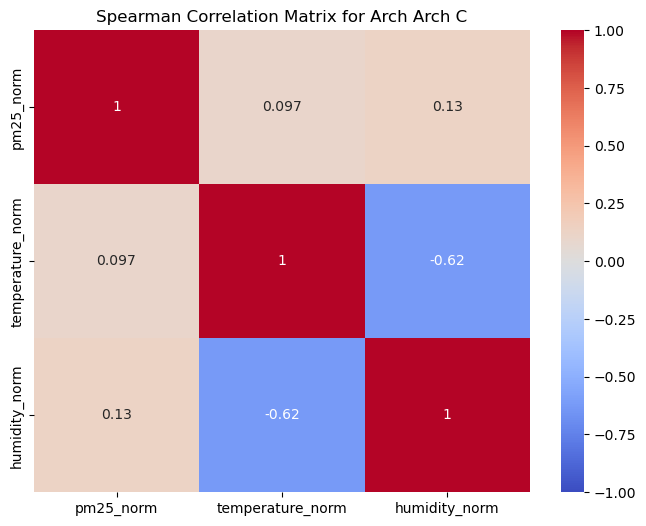

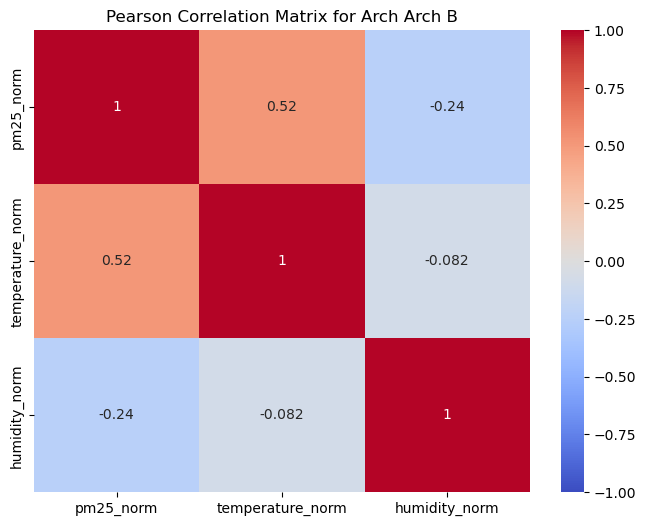

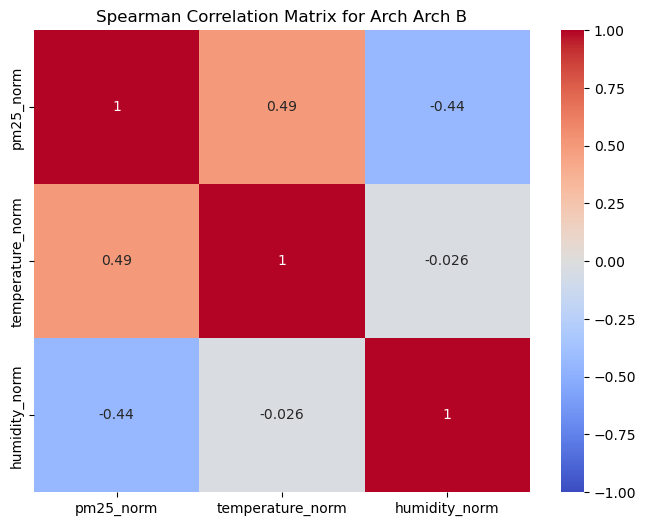

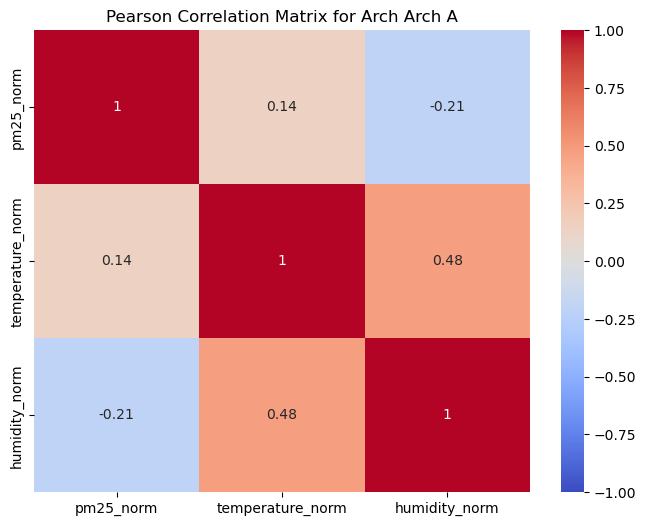

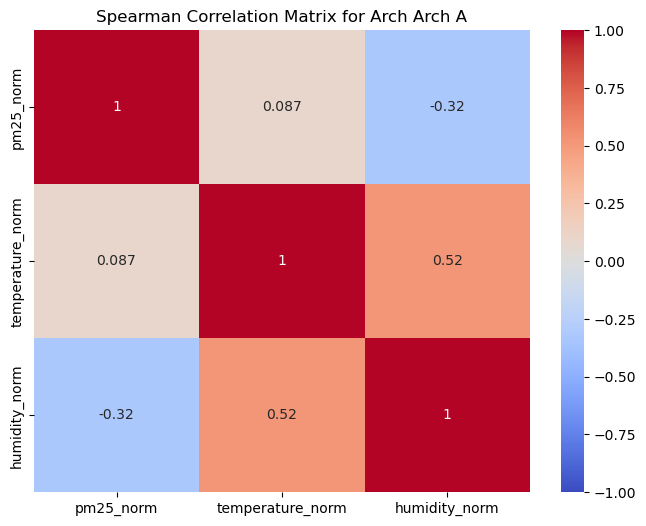

In [139]:
# List of arches and relevant variables
arches = df_filtered['arch'].unique()
correlations = []

# Create empty lists to store the matrices
pearson_matrices = []
spearman_matrices = []

# For each arch, calculate Pearson's and Spearman's correlation matrices
for arch in arches:
    arch_data = df_filtered[df_filtered['arch'] == arch]
    
    # Remove rows with NaN or Inf values in the relevant columns
    arch_data_clean = arch_data[
        arch_data[['pm25_norm', 'temperature_norm', 'humidity_norm']].applymap(np.isfinite).all(axis=1)
    ]
    
    # Create a DataFrame for correlation calculations
    arch_data_clean = arch_data_clean[['pm25_norm', 'temperature_norm', 'humidity_norm']]
    
    # Calculate Pearson and Spearman correlation matrices
    pearson_matrix = arch_data_clean.corr(method='pearson')
    spearman_matrix = arch_data_clean.corr(method='spearman')
    
    # Store the matrices
    pearson_matrices.append(pearson_matrix)
    spearman_matrices.append(spearman_matrix)
    
    # Store the correlations for later inspection
    correlations.append({
        'arch': arch,
        'pearson': pearson_matrix.to_dict(),
        'spearman': spearman_matrix.to_dict()
    })

# Now, plot the correlation matrices for each arch
for idx, arch in enumerate(arches):
    # Pearson correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(pearson_matrices[idx], annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar=True)
    plt.title(f'Pearson Correlation Matrix for Arch {arch}')
    plt.show()
    
    # Spearman correlation matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(spearman_matrices[idx], annot=True, cmap='coolwarm', center=0, vmin=-1, vmax=1, cbar=True)
    plt.title(f'Spearman Correlation Matrix for Arch {arch}')
    plt.show()


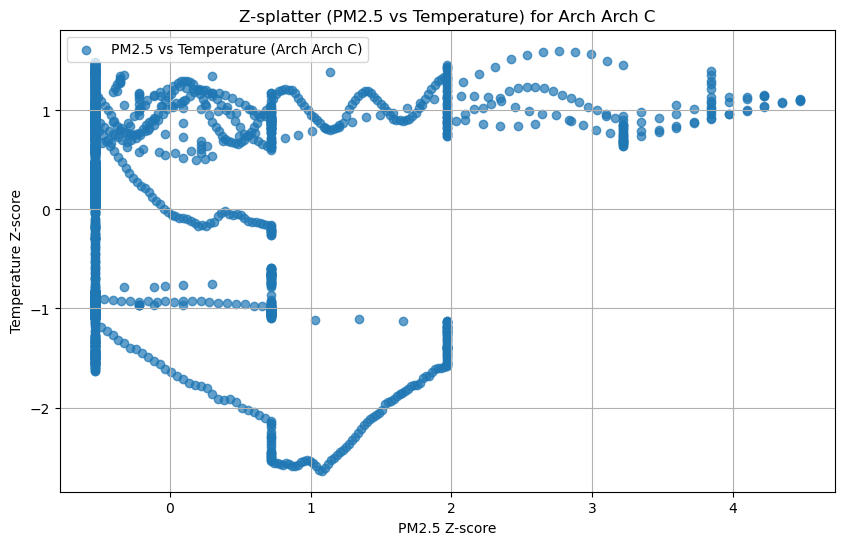

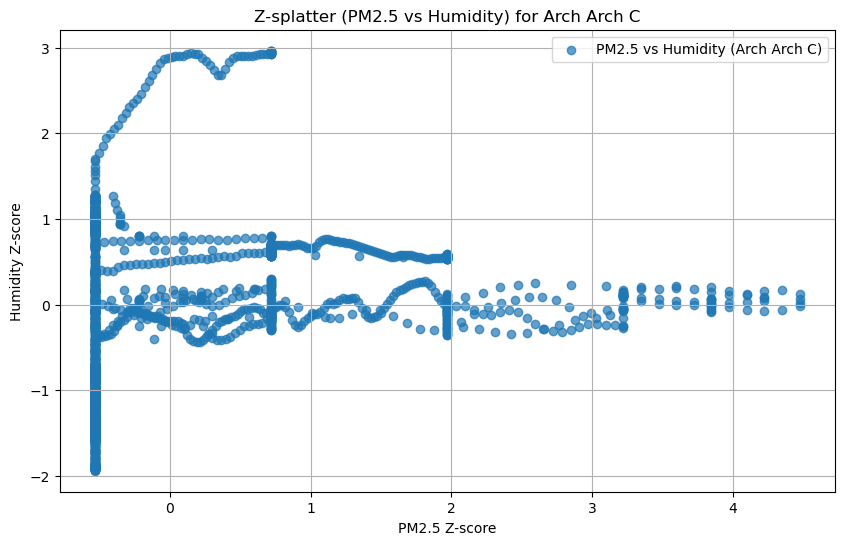

/var/folders/mq/m_d5swdn2t55v6jf5t1mx7240000gp/T/ipykernel_30496/1355729299.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arch_data_clean[['pm25_z', 'temperature_z', 'humidity_z']] = arch_data_clean[['pm25_norm', 'temperature_norm', 'humidity_norm']].apply(zscore)
/var/folders/mq/m_d5swdn2t55v6jf5t1mx7240000gp/T/ipykernel_30496/1355729299.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arch_data_clean[['pm25_z', 'temperature_z', 'humidity_z']] = arch_data_clean[['pm25_norm', 'temperature_norm', 

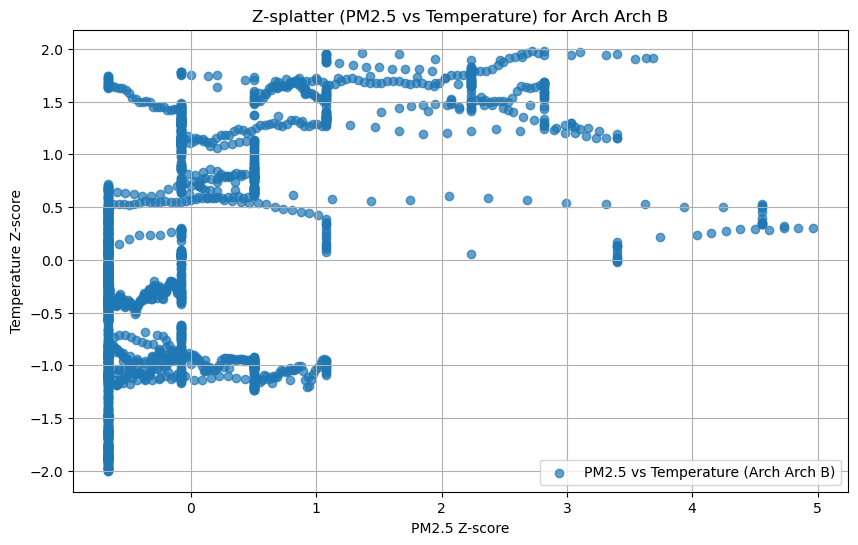

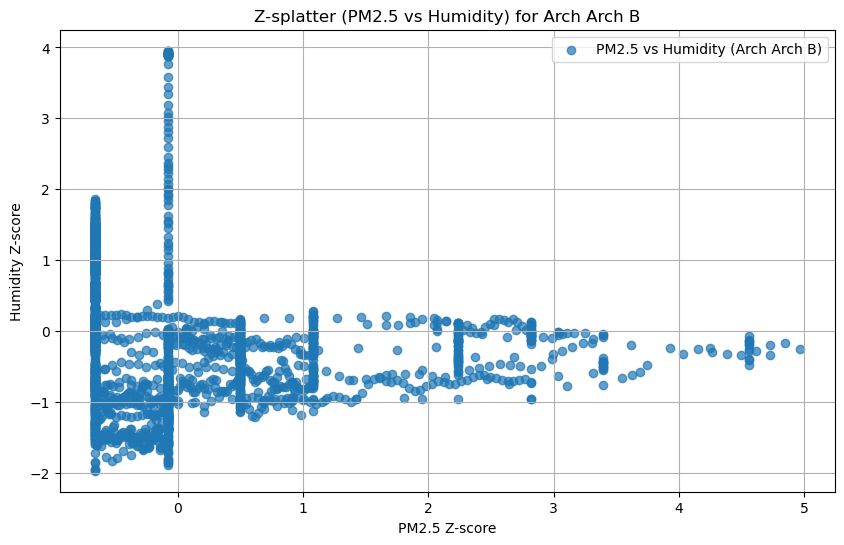

/var/folders/mq/m_d5swdn2t55v6jf5t1mx7240000gp/T/ipykernel_30496/1355729299.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arch_data_clean[['pm25_z', 'temperature_z', 'humidity_z']] = arch_data_clean[['pm25_norm', 'temperature_norm', 'humidity_norm']].apply(zscore)
/var/folders/mq/m_d5swdn2t55v6jf5t1mx7240000gp/T/ipykernel_30496/1355729299.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  arch_data_clean[['pm25_z', 'temperature_z', 'humidity_z']] = arch_data_clean[['pm25_norm', 'temperature_norm', 

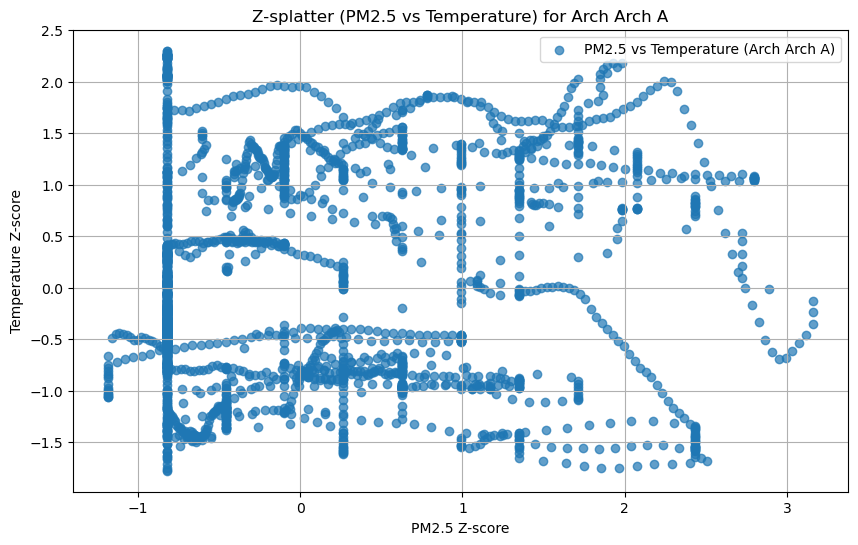

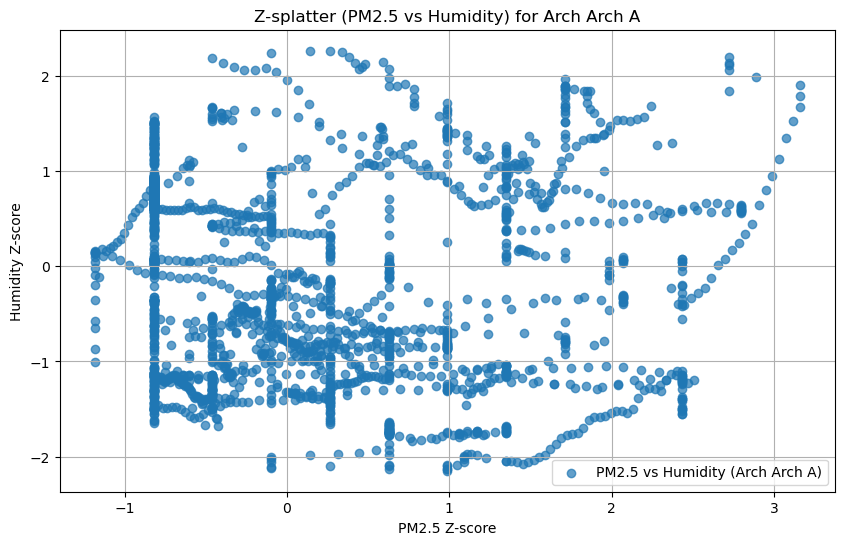

In [143]:
# List of arches and relevant variables
arches = df_filtered['arch'].unique()

# Plotting Z-splatter for each arch
for arch in arches:
    arch_data = df_filtered[df_filtered['arch'] == arch].copy()  # Create a copy to avoid the warning
    
    # Remove rows with NaN or Inf values in the relevant columns
    arch_data_clean = arch_data[
        arch_data[['pm25_norm', 'temperature_norm', 'humidity_norm']].applymap(np.isfinite).all(axis=1)
    ]
    
    # Apply Z-score standardization to the normalized data
    arch_data_clean[['pm25_z', 'temperature_z', 'humidity_z']] = arch_data_clean[['pm25_norm', 'temperature_norm', 'humidity_norm']].apply(zscore)
    
    # Plot Z-splatter for PM2.5 vs Temperature
    plt.figure(figsize=(10, 6))
    plt.scatter(arch_data_clean['pm25_z'], arch_data_clean['temperature_z'], label=f'PM2.5 vs Temperature (Arch {arch})', alpha=0.7)
    plt.title(f'Z-splatter (PM2.5 vs Temperature) for Arch {arch}')
    plt.xlabel('PM2.5 Z-score')
    plt.ylabel('Temperature Z-score')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot Z-splatter for PM2.5 vs Humidity
    plt.figure(figsize=(10, 6))
    plt.scatter(arch_data_clean['pm25_z'], arch_data_clean['humidity_z'], label=f'PM2.5 vs Humidity (Arch {arch})', alpha=0.7)
    plt.title(f'Z-splatter (PM2.5 vs Humidity) for Arch {arch}')
    plt.xlabel('PM2.5 Z-score')
    plt.ylabel('Humidity Z-score')
    plt.grid(True)
    plt.legend()
    plt.show()
